# Plotting the SIFT keypoint detector and feature descriptor error function
This document contains an experiment in which different keypoint detector and feature descriptor combinations are used to detect and uniquely describe common points of interest in image pairs. The goal of this experiment is to explore the effects that varying the values of the different input parameters of the detector/descriptors have on the frequency of inlier matches when computing a 3D relationship between images based upon epipolar geometry.

## Hypothesis

There exists an optimal set of descriptor/detector parameters that can minimize the number of outlier match pairs computer over a set of images.

## Experimental Design
1. Select three image sets:
    1. Nadir Facing Projective Camera.
    2. Nadir Facing Fisheye Camera.
    3. Oblique Camera.
3. Define a bound and a step size for the different parameters.
4. Load the images and initialize the Descriptor/Detector to the openCV initial values.
5. For each image in the image set compute the keypoints and descriptors.
6. For each pair of consecutive images, match corresponding keypoints.
7. Estimate the fundamental matrix between the image pair and compute the inliers and outliers for the image pair.
8. Sum the the number of inliers, outliers and total computed matches for the entire sequence.
9. Select one parameter and vary it by the step size.
10. Repeat steps 5 - 9 while varying the selected parameter until it reaches the bounds.
11. Reset the parameter to its initial value.
12. Select a new parameter to vary and repeat 10.
13. Perform 3 - 12 for each image type.

This experiment will result in a function for each parameter that corresponds to its behaviour about the point corresponding to the openCV initial values.
    
    

## Experiment
To begin we import the necessary python packages including the custom built image processing modules

In [16]:
%matplotlib inline
import image as im
import matching as mt
import imageUtility as ut
import transforms as tn
import numpy as np
import matplotlib.pyplot as plt

### Select three image sets
The following three image datasets are used:
* __Nadir Facing Perspective Camera:__ Glacier images from the Sensefly eBee RTK
* __Nadir Facing Fisheye Camera:__ Images of the Quatre Fourches River in Wood Buffalo National Park, Alberta, Canada
* __Oblique Perspective Camera:__ Images of an office space

In this experiment we operate on the raw, unprojected images. Therefore we do not account for any lense distortion nor the internal imaging geometry.

### Define a bound and a step size for the different parameters
In this experiment we will explore the following parameters:

| Parameter | Description | Initial Value | Step Size | Bounds |
| --- | --- | --- | --- | --- |
|# Features | _desc_ | 10000| 0 | - |
|# Octave Layers | _desc_ | 3| 1 | 1 - 5 |
|Contrast Threshold | _desc_ | 0.04| 0.01 | 0.01 - 0.08 |
|Edge Threshold | _desc_ | 10| 1 | 5 - 15 |
|Sigma | _desc_ | 1.6 | 0.1 | 1.0 - 2.0 | 



In [17]:
nOctaveLayers = 3
contrastThreshold = 0.04
edgeThreshold = 10
sigma = 1.6

imgDir = {'glacier':{'dir':'/home/dennis/Documents/View3D/images/glacier/','ext':'.JPG'},
            'wbnp':{'dir':'/home/dennis/Documents/View3D/images/wbnp/','ext':'.JPG'},
            'desk':{'dir':'/home/dennis/Documents/View3D/images/cathedral/','ext':'.JPG'}
         }

imgRange = range(1,9)

imageParams = {'scale':0.15,
          'kp':'sift',
          'nOctaveLayers':nOctaveLayers,
          'contrastThreshold':contrastThreshold,
          'edgeThreshold':edgeThreshold,
          'sigma':sigma
         }

params = {'nOctaveLayers':{'step':1,'iv':1,'bdy':6},
        'contrastThreshold':{'step':0.01,'iv':0.01,'bdy':0.09},
        'edgeThreshold':{'step':1,'iv':5,'bdy':16},
        'sigma':{'step':0.1,'iv':1.0,'bdy':2.1},
         }

### Open Images and Initialize the Descriptor/Detector to the openCV initial values
A custom function is created, using the image class, which creates an image object for each image in the image set, and compute the keypoints and feature descriptors corresponding to the default openCV values

In [18]:
def openImages(imgRange,imgDir,imgParams,imgSet):
    
    images = []


    for i in imgRange:
        
        images.append(im.image(imgDir[imgSet]['dir'] + str(i) + imgDir[imgSet]['ext'],imgParams))
        
    return images
    

### Plot Results
A custom function is created, using pyplot, which creates a line plots for each parameter variation. The x-axis corresponds to the parameter value, and the y axis correponds to the number of matches. Two curves are plotted:
1. total number of matches.
2. number of outlier matches.

In [19]:
def plotResults(results):
    
    plt.figure(1,figsize=(12,12))
    i = 0
    
    for param in results.keys():
        
        values = np.array(results[param]['value'])
        inlier = np.array(results[param]['inlierCount'])
        outlier = np.array(results[param]['outlierCount'])
        total = inlier+outlier
        
        spVal = 221+i
        
        plt.subplot(spVal)
        plt.plot(values,1.0*outlier/total.max(),label='outlier')
        plt.plot(values,1.0*(outlier+inlier)/(total.max()),label='total matches')
        plt.plot(values,1.0*outlier/(total),label='wi')
        #plt.plot(values,outlier+inlier,label='epsi')
        #plt.plot(values,outlier+inlier,label='metric')
        plt.legend()
        plt.title(param)

        i+=1
        
    plt.subplots_adjust(left=0.10, right=0.95, hspace=0.8, wspace=0.8)

### Experiment
A custom function is created to generate the experimental results. The function can be applied to any keypoint detector and descriptor pair available in the image and matching toolbox.

In [20]:
def computeExperiment(imageSet,params,imageParams):
    
    results = {}
        
    for parameter in params.keys():

        print '*********** ' + parameter + ' ************'
        
        results[parameter] = {'value':[],'inlierCount':[],'outlierCount':[]}
        
        imgParams = {key: value for key, value in imageParams.items()}
        
        imgParams[parameter] = params[parameter]['iv']
        print imgParams
        
        for j in np.arange(imgParams[parameter],params[parameter]['bdy'],params[parameter]['step']):

            imgParams[parameter] = j

            print '*********** ' + str(j) + ' ***********'

            for img in imageSet:

                img.computeKP(imgParams)

            img1 = imageSet[0]
            inlierSum = 0
            outlierSum = 0

            for img2 in imageSet[1:]:

                F = tn.fundamental(img1,img2,imgParams)

                inlierSum += F.inlierCount()
                outlierSum += F.outlierCount()

                img1 = img2   

            results[parameter]['value'].append(imgParams[parameter])
            results[parameter]['inlierCount'].append(inlierSum)
            results[parameter]['outlierCount'].append(outlierSum)
            
    return results
        

## Glacier Images
_Open and initialize the images_

In [21]:
imgSet = openImages(imgRange,imgDir,imageParams,'glacier')

_Compute the experiment._

In [22]:
results = computeExperiment(imgSet,params,imageParams)
imageParams

*********** sigma ************
{'scale': 0.15, 'kp': 'sift', 'edgeThreshold': 10, 'sigma': 1.0, 'nOctaveLayers': 3, 'contrastThreshold': 0.04}
*********** 1.0 ***********
*********** 1.1 ***********
*********** 1.2000000000000002 ***********
*********** 1.3000000000000003 ***********
*********** 1.4000000000000004 ***********
*********** 1.5000000000000004 ***********
*********** 1.6000000000000005 ***********
*********** 1.7000000000000006 ***********
*********** 1.8000000000000007 ***********
*********** 1.9000000000000008 ***********
*********** 2.000000000000001 ***********
*********** nOctaveLayers ************
{'scale': 0.15, 'kp': 'sift', 'edgeThreshold': 10, 'sigma': 1.6, 'nOctaveLayers': 1, 'contrastThreshold': 0.04}
*********** 1 ***********
*********** 2 ***********
*********** 3 ***********
*********** 4 ***********
*********** 5 ***********
*********** contrastThreshold ************
{'scale': 0.15, 'kp': 'sift', 'edgeThreshold': 10, 'sigma': 1.6, 'nOctaveLayers': 3, 'contr

{'contrastThreshold': 0.04,
 'edgeThreshold': 10,
 'kp': 'sift',
 'nOctaveLayers': 3,
 'scale': 0.15,
 'sigma': 1.6}

_Plot the results_

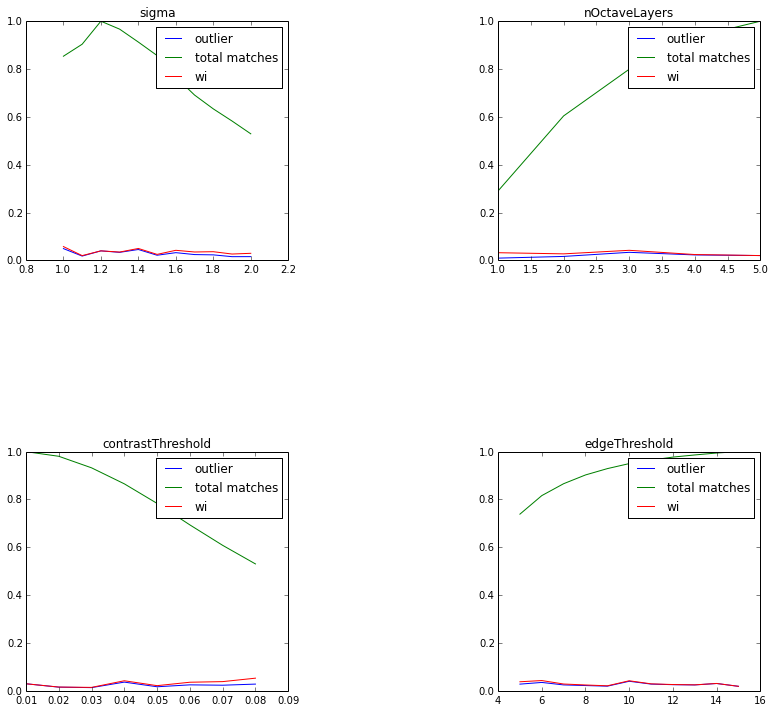

In [23]:
plotResults(results)

_Display results_

In [24]:
results

{'contrastThreshold': {'inlierCount': [20895,
   20783,
   19788,
   17851,
   16507,
   14400,
   12592,
   10819],
  'outlierCount': [634, 330, 286, 782, 363, 535, 503, 603],
  'value': [0.01,
   0.02,
   0.03,
   0.04,
   0.05,
   0.060000000000000005,
   0.06999999999999999,
   0.08]},
 'edgeThreshold': {'inlierCount': [13940,
   15321,
   16502,
   17271,
   17841,
   17851,
   18365,
   18665,
   18861,
   18902,
   19245],
  'outlierCount': [547, 686, 482, 431, 380, 782, 550, 502, 481, 599, 367],
  'value': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
 'nOctaveLayers': {'inlierCount': [6550, 13700, 17851, 21238, 22849],
  'outlierCount': [216, 382, 782, 528, 466],
  'value': [1, 2, 3, 4, 5]},
 'sigma': {'inlierCount': [19561,
   21541,
   23353,
   22695,
   21092,
   20305,
   17851,
   16220,
   14845,
   13793,
   12488],
  'outlierCount': [1195, 435, 964, 814, 1102, 519, 782, 587, 557, 374, 378],
  'value': [1.0,
   1.1,
   1.2000000000000002,
   1.3000000000000003,
   1.400000

## Wood Buffalo Images
_Open and initialize the images_

In [25]:
imgSet = openImages(imgRange,imgDir,imageParams,'wbnp')

_Compute the experiment._

In [14]:
results = computeExperiment(imgSet,params,imageParams)
imageParams

*********** sigma ************
{'scale': 0.15, 'kp': 'sift', 'edgeThreshold': 10, 'sigma': 1.0, 'nOctaveLayers': 3, 'contrastThreshold': 0.04}
*********** 1.0 ***********
*********** 1.1 ***********
*********** 1.2 ***********
*********** 1.3 ***********
*********** 1.4 ***********
*********** 1.5 ***********
*********** 1.6 ***********
*********** 1.7 ***********
*********** 1.8 ***********
*********** 1.9 ***********
*********** 2.0 ***********
*********** nOctaveLayers ************
{'scale': 0.15, 'kp': 'sift', 'edgeThreshold': 10, 'sigma': 1.6, 'nOctaveLayers': 1, 'contrastThreshold': 0.04}
*********** 1 ***********
*********** 2 ***********
*********** 3 ***********
*********** 4 ***********
*********** 5 ***********
*********** contrastThreshold ************
{'scale': 0.15, 'kp': 'sift', 'edgeThreshold': 10, 'sigma': 1.6, 'nOctaveLayers': 3, 'contrastThreshold': 0.01}
*********** 0.01 ***********
*********** 0.02 ***********
*********** 0.03 ***********
*********** 0.04 *********

{'contrastThreshold': 0.04,
 'edgeThreshold': 10,
 'kp': 'sift',
 'nOctaveLayers': 3,
 'scale': 0.15,
 'sigma': 1.6}

_Plot Results_

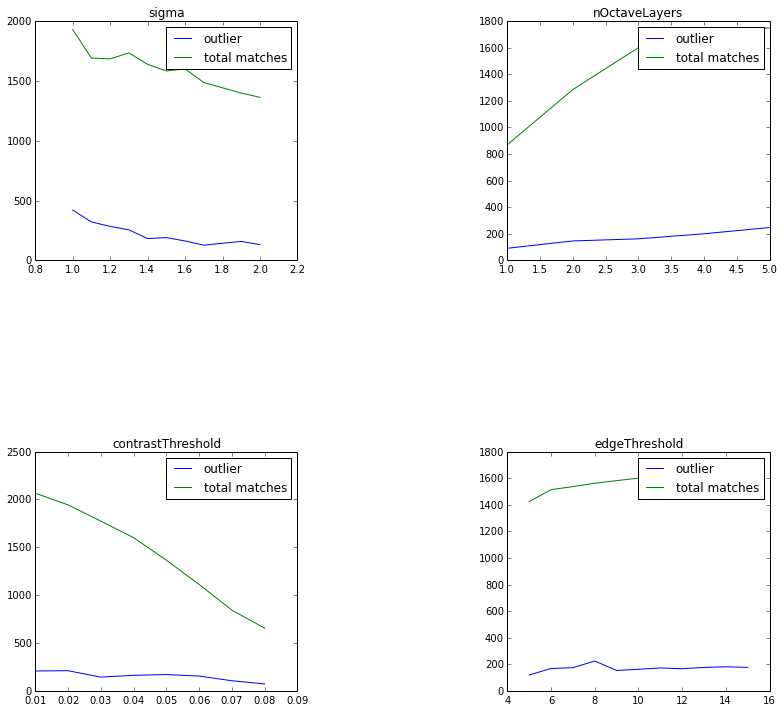

In [15]:
plotResults(results)

_Results_

In [16]:
results

{'contrastThreshold': {'inlierCount': [1859,
   1734,
   1631,
   1439,
   1196,
   958,
   738,
   583],
  'outlierCount': [207, 210, 143, 162, 170, 154, 105, 72],
  'value': [0.01,
   0.02,
   0.029999999999999999,
   0.040000000000000001,
   0.050000000000000003,
   0.060000000000000005,
   0.069999999999999993,
   0.080000000000000002]},
 'edgeThreshold': {'inlierCount': [1305,
   1346,
   1363,
   1338,
   1429,
   1439,
   1442,
   1452,
   1452,
   1455,
   1462],
  'outlierCount': [119, 168, 174, 224, 153, 162, 172, 166, 176, 181, 176],
  'value': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
 'nOctaveLayers': {'inlierCount': [779, 1140, 1439, 1525, 1502],
  'outlierCount': [91, 146, 162, 200, 247],
  'value': [1, 2, 3, 4, 5]},
 'sigma': {'inlierCount': [1510,
   1371,
   1401,
   1480,
   1457,
   1394,
   1439,
   1360,
   1300,
   1241,
   1232],
  'outlierCount': [421, 321, 284, 255, 182, 190, 162, 127, 143, 158, 131],
  'value': [1.0,
   1.1000000000000001,
   1.20000000000000

## Office Images
_Open and initialize the images_

In [24]:
imageParams['scale']=1
imgSet = openImages(imgRange,imgDir,imageParams,'desk')

In [25]:
imgSet[0].showImage()

_Compute Experiment_

In [26]:
results = computeExperiment(imgSet,params,imageParams)
imageParams

*********** sigma ************
{'scale': 1, 'kp': 'sift', 'edgeThreshold': 10, 'sigma': 1.0, 'nOctaveLayers': 3, 'contrastThreshold': 0.04}
*********** 1.0 ***********
*********** 1.1 ***********
*********** 1.2 ***********
*********** 1.3 ***********
*********** 1.4 ***********
*********** 1.5 ***********
*********** 1.6 ***********
*********** 1.7 ***********
*********** 1.8 ***********
*********** 1.9 ***********
*********** 2.0 ***********
*********** nOctaveLayers ************
{'scale': 1, 'kp': 'sift', 'edgeThreshold': 10, 'sigma': 1.6, 'nOctaveLayers': 1, 'contrastThreshold': 0.04}
*********** 1 ***********
*********** 2 ***********
*********** 3 ***********
*********** 4 ***********
*********** 5 ***********
*********** contrastThreshold ************
{'scale': 1, 'kp': 'sift', 'edgeThreshold': 10, 'sigma': 1.6, 'nOctaveLayers': 3, 'contrastThreshold': 0.01}
*********** 0.01 ***********
*********** 0.02 ***********
*********** 0.03 ***********
*********** 0.04 ***********
******

{'contrastThreshold': 0.04,
 'edgeThreshold': 10,
 'kp': 'sift',
 'nOctaveLayers': 3,
 'scale': 1,
 'sigma': 1.6}

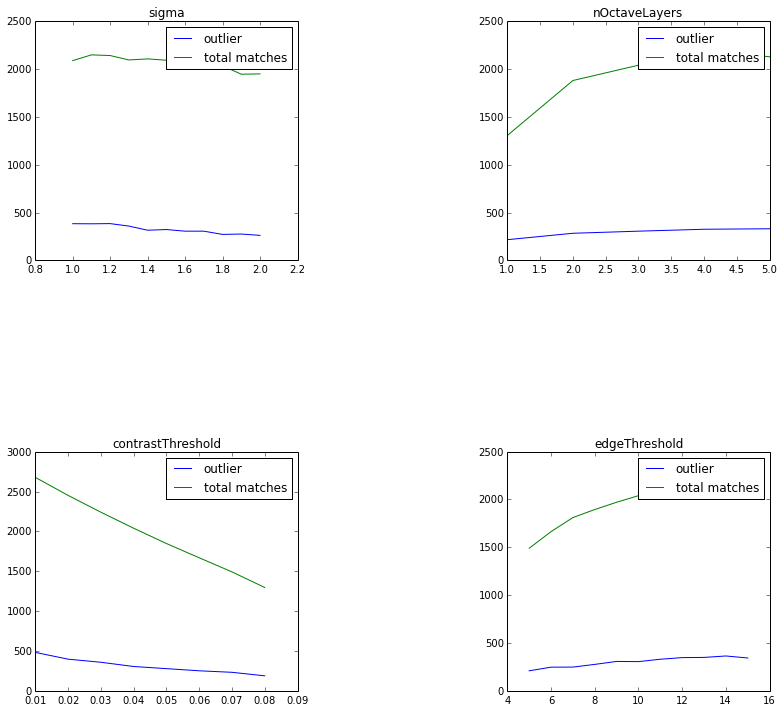

In [27]:
plotResults(results)

In [28]:
results

{'contrastThreshold': {'inlierCount': [2196,
   2055,
   1883,
   1735,
   1570,
   1418,
   1260,
   1108],
  'outlierCount': [482, 397, 358, 305, 278, 251, 232, 188],
  'value': [0.01,
   0.02,
   0.029999999999999999,
   0.040000000000000001,
   0.050000000000000003,
   0.060000000000000005,
   0.069999999999999993,
   0.080000000000000002]},
 'edgeThreshold': {'inlierCount': [1281,
   1417,
   1563,
   1619,
   1664,
   1735,
   1771,
   1817,
   1847,
   1870,
   1929],
  'outlierCount': [209, 247, 248, 276, 307, 305, 330, 347, 349, 364, 343],
  'value': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
 'nOctaveLayers': {'inlierCount': [1089, 1597, 1735, 1877, 1798],
  'outlierCount': [216, 283, 305, 325, 330],
  'value': [1, 2, 3, 4, 5]},
 'sigma': {'inlierCount': [1705,
   1766,
   1757,
   1737,
   1791,
   1770,
   1735,
   1760,
   1762,
   1671,
   1688],
  'outlierCount': [383, 382, 384, 358, 315, 322, 305, 305, 271, 275, 261],
  'value': [1.0,
   1.1000000000000001,
   1.20000000